In [1]:
%matplotlib inline
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
from collections import defaultdict

# 一些有用的工具函数

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=len(v))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def g_clip(v):
    n = np.linalg.norm(v, ord=2)
    if n > 1:
        return v / n
    else:
        return v

# 机器学习

```{admonition} 学习目标
阅读本章后，您将能够：
- 描述和实现基础梯度下降算法
- 使用高斯机制实现差分隐私梯度下降
- 裁剪梯度，保证任意损失函数都可实现差分隐私保护
- 描述噪声给训练过程带来的影响
```

本章我们将探索如何构建差分隐私学习分类器。我们将重点关注一类特定的*监督学习*问题：给定一组*带标签的训练样本*$\{(x_1, y_1), \dots, (x_n, y_n)\}$，其中$x_i$称为*特征向量*，$y_i$称为*标签*，我们要训练一个*模型*$\theta$。该模型可以*预测*没有在训练集中出现过的新特征向量所对应的标签。一般来说，每个$x_i$都是一个描述训练样本特征的实数向量，而$y_i$是从预先定义好的*类型*集合中选取的，每个类型一般用一个整数来表示。我们预先要从全部样本中提取出所有可能的类型，构成类型集合。一个二分类器的类型集合应包含两个类型（一般分别用1和0，或1和-1表示）。

## 使用Scikit-Learn实现逻辑回归

您可以从下述链接下载所需的数据集：

- [`adult_processed_x`](https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_processed_x.npy)
- [`adult_processed_y`](https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_processed_y.npy)

In [2]:
X = np.load('adult_processed_x.npy')
y = np.load('adult_processed_y.npy')

当要训练一个模型时，我们从所有可用的数据中选择一些数据来构造一组*训练样本*（如前所述），但我们也会留出一些数据作为*测试样本*。一旦训练完模型，我们肯定想要知道该模型在*非*训练样本上的表现如何。如果一个模型在未知的新样本上表现很好，我们称其*泛化*能力很好。一个泛化能力*不足*的模型，我们称其在训练数据上发生了*过拟合*。

我们使用测试样本来测试模型的泛化能力。由于我们事先已知测试样本的标签，我们可以让模型对每个测试样本进行分类，并比较预测标签和真实标签的结果，以测试模型的泛化能力。我们将把数据集切分为训练集和测试集。训练集包含80%的样本，而测试集包含其余20%的样本。


In [3]:
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

y_test.shape

(9044,)

构建一个二分类器的简单方法是使用*逻辑回归（Logistic Regression）*。scikit-learn库包含了一个实现逻辑回归的内置模块，名为`LogisticRegression`。通过调用此内置模块，很容易应用我们的数据构建二分类模型。

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train[:1000],y_train[:1000])
model

LogisticRegression()

接下来，我们可以使用模型的`predict`（预测）方法预测测试集的标签。

In [5]:
model.predict(X_test)

array([-1., -1., -1., ..., -1., -1., -1.])

我们的模型预测对了多少个测试样本呢？我们可以比较预测标签和真实标签的结果。如果用预测正确的标签数量除以测试样本总数，我们就可以计算出测试样本的预测准确率。

In [6]:
np.sum(model.predict(X_test) == y_test)/X_test.shape[0]

0.8243034055727554

我们的模型对测试样本的标签预测准确率为82%。对该数据集来说，这是一个相当不错的预测准确率。

## 模型是什么？

模型到底*是*什么？它是如何编码预测所用信息的？

有很多种不同类型的模型。这里我们要探讨的是*线性模型（Linear Model）*。给定一个包含$k$-维特征向量$x_1, \dots, x_k$的无标签样本，线性模型预测此样本的标签时，将计算下述值：

\begin{align}
w_1 x_1 + \dots + w_k x_k + bias
\end{align}

并用此值的符号作为预测标签（如果此值为负数，则预测结果为-1；如果此值为正数，则预测结果为1）。

此模型可以用一个由$w_1, \dots, w_k$和$bias$组成的向量来表示。之所以称该模型是线性模型，是因为模型在预测时要计算一个1次多项式（即线性多项式）的值。$w_1, \dots, w_k$通常被称为模型的*权重*或*系数*，$bias$则被称为*偏差项*或*截距*。

这实际上也是scikit-learn表示逻辑回归模型的方式！我们可以使用模型的`coef_`属性来查看训练得到的模型权重：

In [7]:
model.intercept_[0], model.coef_[0]

(-5.346167750305752,
 array([ 3.76035057e-01, -2.55358856e-01, -3.21341426e-02,  3.74545737e-01,
        -6.85885223e-01,  3.91875239e-01, -1.69476241e-01, -7.41793527e-02,
        -5.76496538e-01,  3.94976503e-01, -3.41457312e-01, -6.24912317e-01,
        -6.05605602e-01, -4.56928100e-01, -5.19167009e-01, -1.05743009e-01,
         8.19586633e-01,  9.96762702e-01, -3.09342985e-01,  6.57277160e-01,
        -1.06436104e-01,  7.71287796e-01,  7.99791034e-02,  1.43803702e-01,
        -1.01006564e-01,  1.59416785e+00, -5.06233997e-02, -5.78477239e-01,
        -3.72601413e-01, -6.35661364e-01, -1.02810175e-01,  0.00000000e+00,
        -1.35478173e-01,  4.36864993e-01, -3.42554362e-01, -1.32819675e-01,
        -2.00200285e-01, -1.53919241e+00,  6.44831702e-02,  7.17836796e-01,
         3.80039408e-01,  4.25898498e-02,  8.81653483e-01, -7.08110462e-02,
         6.10385977e-02,  8.94590966e-02,  6.93679716e-01, -1.30382712e+00,
        -6.55878656e-01,  1.11512993e+00,  3.78012650e-01, -4.28231

注意到，权重$w_i$的数量和特征$x_i$的数量总是一致的，因为模型在预测时需要将各个特征和其对应的权重相乘。这也意味着我们模型的维度和特征向量的维度完全相同。

有了获得权重和偏差项的方法后，我们就可以实现自己的预测函数了：

In [8]:
# 预测：以模型（theta）单一样本（xi）为输入，返回预测标签
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

np.sum(predict(X_test, model.coef_[0], model.intercept_[0]) == y_test)/X_test.shape[0]

0.8243034055727554

这里我们将偏差项设置为可选参数，因为在大多数情况下，无偏差项模型的预测效果也足够好了。为了简化模型训练的整个过程，后续我们先不考虑训练偏差项。

## 使用梯度下降训练模型

训练过程究竟是如何进行的呢？scikit-learn库实现了一些非常复杂的算法，但我们也可以通过实现一个简单算法来实现同等的效果。此算法称为*梯度下降*（Gradient Descent）。

大多数机器学习训练算法要根据所选择的*损失函数*（Loss Function）来定义。损失函数是一种衡量模型预测结果有多"差"的方法。训练算法的目标是使损失函数达到最小值。换句话说，损失值低的模型具有*更好的*预测能力。

机器学习社区已经提出了多种不同的常用损失函数。对于每个预测正确的样本，简单的损失函数直接返回0。对于每个预测错误的样本，损失函数直接返回1。损失值为0意味着模型可以正确预测出每个样本的标签。二分类器中较为常用的损失函数为*对率损失*（Logistic Loss）。对率损失帮助我们度量出模型"还有多远的距离"才能正确预测出标签（与简单地输出0和1相比，对率损失可以提供更多的信息）。

下述Python代码实现了对率损失函数：

In [9]:
# 损失函数用于衡量我们的模型有多好。训练目标是最小化损失值。
# 这是对率损失函数。
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

我们可以使用损失函数衡量指定模型的效果。让我们用权重全为0的模型来试一试。该模型大概率效果不佳，但我们可以把此模型作为起点，逐步训练出更好的模型。

In [10]:
theta = np.zeros(X_train.shape[1])
loss(theta, X_train[0], y_train[0])

0.6931471805599453

一般来说，通过简单地计算所有训练样本的平均损失值，我们就可以测量出模型在整个训练集上有多好。当模型的权重全为0时，所有样本*全部*预测错误，整个训练集的平均损失值刚好等于我们前面计算得到的单个样本损失值。

In [11]:
np.mean([loss(theta, x_i, y_i) for x_i, y_i in zip(X_train, y_train)])

0.6931471805599453

我们*训练*模型的目标是*最小化*损失值。这里的关键问题是：我们如何修改模型才能降低损失值呢？

梯度下降是一种根据[*梯度*](https://en.wikipedia.org/wiki/Gradient)更新模型以降低损失值的方法。梯度就像一个多维导数：对于一个有着多维输入的函数（例如我们前面提到的损失函数），梯度告诉我们*每个*维度输入的变化会在多大程度上影响函数输出的变化。如果某一维度的梯度为正，意味着一旦我们增加该维度的模型权重，函数输出值将*变大*。我们想要*降低*损失值，因此我们应该用*负*梯度来修改模型，即做与梯度*相反*的事情。由于我们沿梯度的相反方向修改模型，因此这一过程称为*降低*梯度。

当我们经过多次迭代，重复执行此下降过程后，我们会越来越接近最小化损失值的模型。这就是*梯度下降*的整个过程。让我们来看看梯度下降算法在Python下的运行效果。首先，我们定义梯度函数。

In [12]:
# 这是对率损失函数的梯度
# 梯度是一个表示各个方向损失变化率的向量
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

### 单步梯度下降

接下来，我们来单步执行一次梯度下降。我们将训练集中的一个样本都输入到`gradient`（梯度）函数中，得到此样本的梯度值。得到梯度值可以为我们提供足够信息来改善模型。我们在当前模型`theta`上减去得到的梯度，以实现梯度"下降"。

In [13]:
# 如果我们想把我们向梯度的反方向移动一步（即减去梯度值），
# 我们应该可以让theta向损失值*变小）的方向移动
# 这就是单步梯度下降。我们在每一步都要尝试*降低*梯度
# 在这个例子中，我们只计算了训练集中（第）一个样本的梯度
theta = theta - gradient(theta, X_train[0], y_train[0])
theta

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        ,  0.        ,  0.        , -0.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.5       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.5       ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        , -0.5       ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

现在，如果我们以相同的训练样本为输入调用`predict`函数，模型就可以正确预测此样本的标签了！我们的模型更新方法确实提高了模型的预测能力，因为更新后的模型已经具备分类此样本的能力了。

In [14]:
y_train[0], predict(theta, X_train[0])

(-1.0, -1.0)

我们需要多次度量模型的准确性。为此，我们定义一个用于度量准确性的辅助函数。它的工作方式和sklearn模型的准确性度量方式相同。我们可以用这个函数度量经过单个样本梯度下降后所得到的模型`theta`，看看新模型在测试集的效果怎么样。

In [15]:
def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

accuracy(theta)

0.7585139318885449

我们改善后的模型现在可以正确预测测试集中75%的标签！这是一个很大的进步，我们大大改善了模型的预测效果。

### 梯度下降算法

我们需要进一步对算法的两个部分进行改进，从而最终实现基础梯度下降算法。第一，我们前面的单步梯度下降仅使用了训练数据中的单个样本。我们希望用*整个*训练集来更新模型，从而改善模型在*所有*样本上的预测效果。第二，我们需要执行多次迭代，尽可能让损失值达到最小。

对于第一个改进点，我们可以计算所有训练样本的*平均梯度*，以替代单步梯度下降中的单样本梯度。我们用下述实现的`avg_grad`（平均梯度）函数来计算所有训练样本和对应标签的平均梯度。

In [16]:
def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

avg_grad(theta, X_train, y_train)

array([-8.03202480e-03, -1.09365062e-02, -5.86649848e-02, -1.70297784e-02,
       -1.85949049e-02, -5.32762100e-03,  3.15432083e-05,  2.24692568e-03,
        1.80942171e-03,  1.10891317e-03,  7.17940863e-04,  1.22012681e-03,
        1.09385854e-03,  1.42352970e-03, -4.29266203e-03, -5.73114012e-03,
       -4.96409990e-02, -7.90844879e-03, -1.08970068e-02, -2.50609905e-02,
        3.27410319e-04, -1.20102580e-02, -1.29608985e-02,  1.15182321e-02,
       -2.26895536e-04, -1.83255483e-01,  1.34642262e-03,  4.47703452e-02,
        4.31895523e-03,  2.97414610e-03,  6.16295082e-03, -4.88903955e-05,
       -2.13933205e-02, -4.86969833e-02, -8.62802483e-04,  3.11463168e-03,
        1.23013848e-03,  1.54486498e-02,  1.21336873e-03, -4.38864985e-02,
       -4.34689131e-03, -1.64743409e-02, -4.53583200e-03, -5.47845717e-03,
       -1.67472715e-01,  1.93015718e-02,  4.73608091e-03,  2.44149704e-02,
        1.61917788e-02, -1.57259641e-02,  6.59058497e-04, -1.58429762e-03,
        9.21938268e-03,  

对于第二个改进点，我们来定义一个可以多次执行梯度下降的迭代算法。

In [17]:
def gradient_descent(iterations):
    # 我们用"猜测"的一个模型参数（权重全为0的模型）作为起始点
    theta = np.zeros(X_train.shape[1])

    # 应用训练集迭代执行梯度下降步骤
    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)

    return theta

In [18]:
theta = gradient_descent(10)
accuracy(theta)

0.7787483414418399

经过10轮迭代，我们的模型几乎达到78%的准确率，效果还不错！我们的梯度下降算法看起来很简单（也确实挺简单的！），但这个算法可以说是大智若愚：该方法是近年来绝大多数大规模深度学习的基础。我们给出的算法在设计上已经非常接近于TensorFlow等主流机器学习框架所实现的算法了。

注意到，与前面用sklearn训练得到的模型相比，我们的模型还没有达到84%的准确率。别担心，我们的算法绝对有能力做到！我们只是需要更多轮迭代，使损失值更接近最小值。

经过100轮迭代，模型的准确率达到82%，更接近84%的准确率了。但是，如此多的迭代次数导致算法运行了非常长的时间。更糟糕的是，我们越接近最小损失值，模型的预测效果就越难得到进一步的改善了。100轮迭代后的模型可以达到82%的准确率，但达到84%的准确率可能需要1000轮迭代。这也体现出了机器学习的一个根本矛盾：一般来说，更多的训练轮数可以带来更高的准确率，但同时也需要更多的计算时间。在实际场景中使用大规模深度学习时，绝大多数实现"技巧"都是为梯度下降的每轮迭代加速，以便在相同时间内执行更多轮迭代。

还有一个有趣的现象值得我们注意：损失函数的输出值确实会随着每轮梯度下降的迭代而下降。因此，随着执行轮数的增加，我们的模型的确在逐渐接近最小损失值。另外要注意的是，如果训练集和测试集的损失值非常接近，意味着我们的模型没有*过拟合*训练数据。

In [19]:
def gradient_descent_log(iterations):
    theta = np.zeros(X_train.shape[1])

    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)
        print(f'训练集损失值: {np.mean(loss(theta, X_train, y_train))}')
        print(f'测试集损失值: {np.mean(loss(theta, X_test, y_test))}\n')

    return theta

gradient_descent_log(5);

Training loss: 0.549109439168421
Testing loss: 0.5415350837580458

Training loss: 0.5224689105514977
Testing loss: 0.5162665121068426

Training loss: 0.5028090736020403
Testing loss: 0.49753785424732383

Training loss: 0.4878874803989895
Testing loss: 0.48335633696635527

Training loss: 0.47628573924997936
Testing loss: 0.4723742456095848



## 差分隐私梯度下降

我们如何使上述算法满足差分隐私呢？我们想要设计一种算法来为训练数据提供差分隐私保护，使最终训练得到的模型不会泄露与单个训练样本相关的任何信息。

算法执行过程中唯一使用了训练数据的部分是梯度计算步骤。使该算法满足差分隐私的一种方法是，在每轮模型更新前在梯度上增加噪声。由于我们直接在梯度上增加噪声，因此该方法通常被称为*噪声梯度下降*（Noisy Gradient Descent）。

我们的梯度函数是向量值函数，因此我们使用`gaussian_mech_vec`（向量高斯机制）在梯度函数的输出值上增加噪声：

In [20]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = '???'

    for i in range(iterations):
        grad = avg_grad(theta, X_train, y_train)
        noisy_grad = gaussian_mech_vec(grad, sensitivity, epsilon, delta)
        theta = theta - noisy_grad

    return theta

这里就差一块拼图了：**梯度函数的敏感度是多少**？这是使算法满足差分隐私的关键所在。

这里我们主要面临两个挑战。第一，梯度是*均值问询*的结果，即梯度是每个样本梯度的均值。我们之前已经提到，最好将均值问询拆分为一个求和问询和一个计数问询。做到这一点并不难，我们可以不直接计算梯度均值，而是计算每个样本梯度噪声和，再除以噪声计数值。第二，我们需要限制每个样本梯度的敏感度。有两种基础方法可以做到这一点。我们可以（如之前讲解的其他问询那样）分析梯度函数，确定其在最差情况下的全局敏感度。我们也可以（如"采样-聚合"框架那样）裁剪梯度函数的输出值，从而*强制*限定敏感度上界。

我们先介绍第二种方法。第二种方法从概念上看更简单，在实际应用中的普适性更好。此方法一般被称为*梯度裁剪*（Gradient Clipping）。

### 梯度裁剪

回想一下，在实现"采样-聚合"框架时，我们裁剪未知敏感度函数$f$的输出，强制限定$f$的敏感度上界。$f$的敏感度为：

\begin{align}
\lvert f(x) - f(x') \rvert
\end{align}

使用参数$b$裁剪后，上述表达式变为：

\begin{align}
\lvert \mathsf{clip}(f(x), b) - \mathsf{clip}(f(x'),b) \rvert
\end{align}

最差情况下，$\mathsf{clip}(f(x), b) = b$，且$\mathsf{clip}(f(x'),b) = 0$，因此裁剪结果的敏感度为$b$（即敏感度等于裁剪参数）。

我们可以使用相同的技巧来限定梯度函数的$L2$敏感度。我们需要定义一个用来"裁剪"向量的函数，使输出向量的$L2$范数落在期望的范围内。我们可以通过*缩放*向量来做到这一点：如果把向量中每个位置的元素都除以向量的$L2$范数，则所得向量的$L2$范数为1。如果想要使用裁剪参数$b$，我们可以在缩放后的向量上乘以$b$，将其放大回$L2$范数等于$b$的向量。我们还希望不对$L2$范数已经小于$b$的向量进行任何修改。因此，如果向量的$L2$范数已经小于$b$，我们直接返回此向量即可。我们可以使用`np.linalg.norm`函数，并以参数`ord=2`作为输入，以计算向量的$L2$范数。

In [24]:
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    
    if norm > b:
        return b * (v / norm)
    else:
        return v

现在，我们可以开始分析裁剪梯度的敏感度了。我们将梯度表示为$\nabla(\theta; X, y)$（对应我们Python代码中的`gradient`）：

\begin{align}
\lVert \mathsf{L2\_clip}( \nabla (\theta; X, y), b) - \mathsf{L2\_clip}( \nabla (\theta; X', y), 0) \rVert_2
\end{align}

最差情况下，$\mathsf{L2\_clip}( \nabla (\theta; X, y), b)$的$L2$范数为$b$，且$\mathsf{L2\_clip}( \nabla (\theta; X', y))$全为0。此时，两者的$L2$范数差等于$b$。这样一来，我们成功用裁剪参数$b$限定了梯度的$L2$敏感度上界！

现在，我们可以继续计算裁剪梯度之和，并根据我们通过裁剪技术得到的$L2$敏感度上界$b$来增加噪声。

In [21]:
def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
        
    # 求和问询
    # （经过裁剪后的）L2敏感度为b
    return np.sum(gradients, axis=0)

我们现在就快要完成噪声梯度下降算法的设计和实现了。为了计算平均噪声梯度，我们需要：

1. 基于敏感度$b$，在梯度和上增加噪声
2. 计算训练样本数量的噪声计数值（敏感度为1）
3. 用(1)的噪声梯度值和除以(2)的噪声计数值

In [22]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, X_train, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

In [25]:
theta = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta)

0.777421494913755

该算法的每轮迭代过程都满足$(\epsilon, \delta)$-差分隐私。我们还需额外执行一次噪声计数问询来得到满足$\epsilon$-差分隐私的噪声计数值。如果执行$k$轮迭代，则根据串行组合性，算法满足$(k\epsilon + \epsilon, k\delta)$-差分隐私。我们也可以使用高级组合性来分析总隐私消耗量。更进一步，我们可以将算法转化为瑞丽差分隐私或零集中差分隐私，应用相应的组合定理得到更紧致的总隐私消耗量。

### 梯度的敏感度

前面所述方法的普适性很高，因为此方法不需要假设梯度函数满足什么特定的要求。但是，我们有时*的确*对梯度函数有所了解。特别地，一大类常用的梯度函数（包括本章用到的对率损失梯度）是*利普希茨连续*（Lipschitz Continuous）的。这意味着这些梯度函数的全局敏感度是有界的。用数学语言描述，我们可以证明：

\begin{align}
\text{If}\; \lVert x_i \rVert_2 \leq b\; \text{then}\; \lVert \nabla(\theta; x_i, y_i) \rVert_2 \leq b
\end{align}

这一结论允许我们通过裁剪*训练样本*（即梯度函数的*输入*）来获得梯度函数的$L2$敏感度上界。这样，我们就不再需要裁剪梯度函数的*输出*了。

用裁剪训练样本代替裁剪梯度会带来两个优点。第一，与预估训练阶段的梯度尺度相比，预估训练样本的尺度（进而选择一个好的裁剪参数）通常要容易得多。第二，裁剪训练样本的计算开销更低：我们只需要对训练样本裁剪一次，训练模型时就可以重复使用裁剪后的训练数据了。但如果选择裁剪梯度，我们就需要裁剪训练过程中计算得到的每一个梯度。此外，为了实现梯度裁剪，我们不得不依次计算出每个训练样本的梯度。但如果选择裁剪训练样本，我们就可以一次计算得到所有训练样本的梯度，从而提高训练效率（这是机器学习中的常用技巧，这里我们不再展开讨论）。

然而，需要注意的是，还有很多常用损失函数的全局敏感度是无界的，尤其是深度学习中神经网络里用到的损失函数更是如此。对于这些损失函数，我们只能使用梯度裁剪法。

我们只需对算法进行简单的修改，就可以把裁剪梯度替换为裁剪训练样本。在开始训练之前，我们需要先使用`L2_clip`（L2裁剪）函数来裁剪训练样本。随后，我们只需要直接把裁剪梯度的代码移除即可。

In [26]:
def gradient_sum(theta, X, y, b):
    gradients = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X,y)]

    # 求和问询
    # （经过裁剪后的）L2敏感度为b
    return np.sum(gradients, axis=0)

In [27]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)
    clipped_X = [L2_clip(x_i, sensitivity) for x_i in X_train]

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, clipped_X, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

In [28]:
theta = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta)

0.7791906236178682

M可以对此算法进行多种改进，以进一步降低隐私消耗量、提升模型预测的准确率。很多改进方法都源自机器学习领域的论文。这里给出几个例子：

- 将总隐私消耗量限定为$\epsilon$，在算法内部计算每轮迭代的隐私消耗量$\epsilon_i$。
- 利用高级组合性、瑞丽差分隐私或零集中差分隐私，从而获得更好的总隐私消耗量。
- 小批次训练：每轮迭代中，不使用整个训练数据，而是使用一小块训练数据来计算梯度（这样可以减少梯度计算过程中的计算开销）。
- 同时使用小批次训练和并行组合性。
- 同时使用小批次训练和小批次随机采样。
- 调整学习率$\eta$等其他超参数。

## 噪声对训练的影响

我们已经知道，迭代次数会对模型的预测准确率带来很大的影响，因为更多的迭代次数可以使模型更接近最小损失值。我们的差分隐私算法需要在梯度上增加噪声，这会对准确率噪声带来很大的影响。噪声可能导致训练算法在训练过程中向*错误的方向*移动，使模型变得*更糟糕*。

我们有理由相信更小的$\epsilon$会带来准确率更低的模型（我们已经学习的差分隐私算法都存在类似的关系）。这个结论确实是正确的，但由于在执行多轮迭代算法时要考虑组合定理，因此这里也存在一些微妙的平衡。更多的迭代次数意味着更大的隐私消耗量，而在标准梯度下降算法中，更多的迭代次数一般意味着产出更好的模型。在差分隐私保护下，当总隐私消耗量保持不变时，更多的迭代次数可能会导致模型变得更加糟糕，因为我们不得不使用更小的$\epsilon$来支持更多轮迭代，这会带来更大的噪声。在差分隐私机器学习中，适当平衡迭代轮数和单轮添加的噪声量是一个很重要的（有时也是一个非常有挑战性的）问题。

让我们做一个小实验，看看不同的$\epsilon$会对模型的预测准确率带来何种影响。我们将使用不同的$\epsilon$来训练模型，每次训练迭代20轮。我们根据训练时使用的$\epsilon$作为横坐标来绘制每个模型的准确率变化图。

In [29]:
delta = 1e-5

epsilons = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1]
thetas   = [noisy_gradient_descent(10, epsilon, delta) for epsilon in epsilons]
accs     = [accuracy(theta) for theta in thetas]

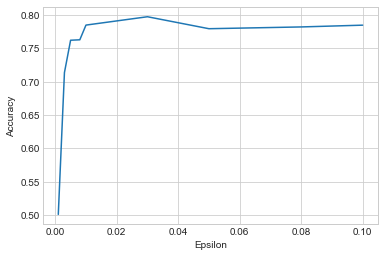

In [30]:
plt.xlabel('ε')
plt.ylabel('准确率')
plt.plot(epsilons, accs);

从上图可以看出，$\epsilon$非常小时会产生准确率非常低的模型。请记住，我们在图中指定的$\epsilon$是每轮迭代时使用的$\epsilon$，因此组合后的总隐私消耗量还要大得多。